In [2]:
import os
import json
from typing import Tuple
import torch
from torch import nn, optim
from sklearn.metrics import roc_auc_score

from models import make_mlp
from utils.model_utils import (
    get_train_val_test_arrays,
    get_tensordataset,
    get_dataloader,
    train_validate_test,
    evaluate_thresholds
)

In [4]:
DATA_DIR = './data/'

### 1. Get Device

In [5]:
# getting device for training MLP
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)
print(f"Device: \"{device}\".")

Device: "cuda".


### 2. Define Helper Function

##### 2.1) Define Function to Load Feature and Target Data

In [6]:
def load_data(
    data_dir: str = DATA_DIR,
    features_file: str = None,
    targets_file: str = None
) -> Tuple:
    """
    Purpose: Load features and labels from JSON files.
    :param data_dir (str): Directory containing the data files.
    :param features_file (str): Name of the features file.
    :param targets_file (str): Name of the targets file.
    :return: Tuple of X (list of feature data) and y (list
        of target data).
    """
    features_loc = os.path.join(data_dir, 'features_data', features_file)
    targets_loc = os.path.join(data_dir, 'targets_data', targets_file)

    with open(features_loc, mode = 'r') as json_f:
        X = json.load(json_f)
    print(f"- {format(len(X), ',')} total rows in features dict.")

    with open(targets_loc, mode = 'r') as json_f:
        y = json.load(json_f)
    print(f"- {format(len(y), ',')} total rows in labels dict.")

    return (X, y)

### 3. Run Experiments

##### 3.1) Define Hyperparameters of Experiments

In [16]:
NUM_EPOCHS = 200
WEIGHT_DECAY = 1.00E-06
NUM_FEATURES = 45

In [17]:
hyperparameters_dict = {
    0: {
        'features_file': '24_MLP_features_dict.json',
        'targets_file': 'targets_dict_anyfailure_24hrfeaturewindow_6hrlookahead.json',
        'learning_rate': 0.001,
        'batch_size': 64,
        'mlp_dropout': 0.0,
        'mlp_layers': [16],
    },
    1: {
        'features_file': '24_MLP_features_dict.json',
        'targets_file': 'targets_dict_anyfailure_24hrfeaturewindow_24hrlookahead.json',
        'learning_rate': 0.001,
        'batch_size': 64,
        'mlp_dropout': 0.0,
        'mlp_layers': [16],
    },
}

##### 3.2) Run Experiments

--------------------------------------------------
*experiment_idx = 0
- 36,500 total rows in features dict.
- 36,500 total rows in labels dict.


Epochs: 100%|██████████| 200/200 [02:35<00:00,  1.29it/s]


	- Best Val AUC Epoch: 185
	- Best Val AUC: 0.9979461784713886
	- Best Test AUC: 0.9942046818727491
	- TPR Target: 0.8
		- Validation Accuracy: 0.9927197802197802
		- Validation Recall: 0.7857142857142857
		- Test Accuracy: 0.9846153846153847
		- Test Recall: 0.2


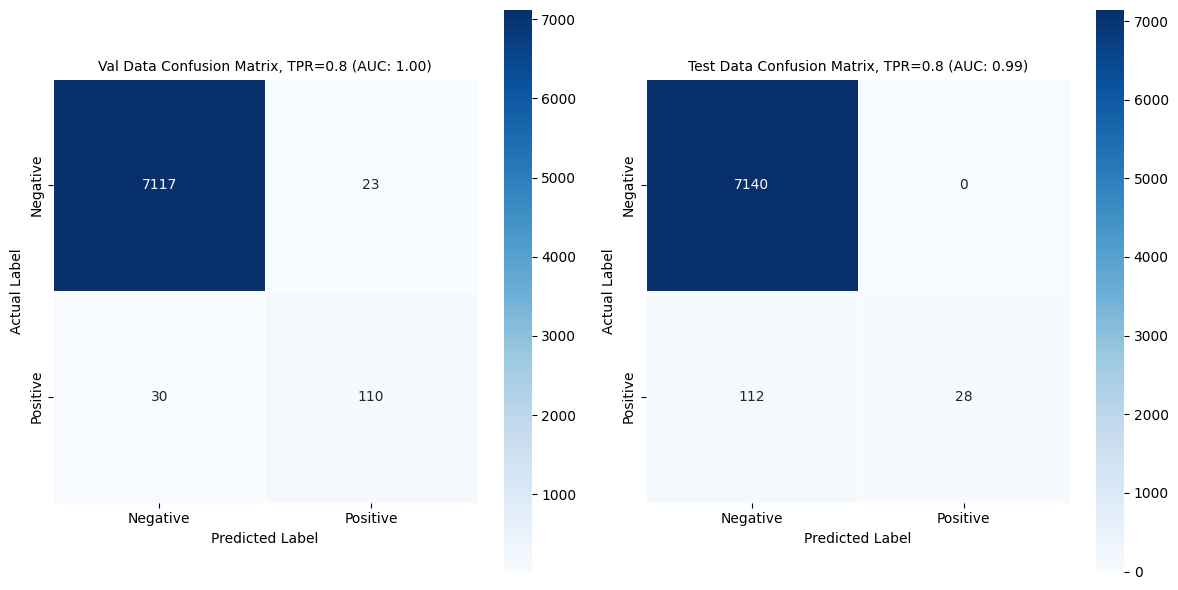

	- FPR Target: 0.05
		- Validation Accuracy: 0.959478021978022
		- Validation Specificity: 0.9588235294117647
		- Test Accuracy: 0.9902472527472528
		- Test Specificity: 0.9949579831932773


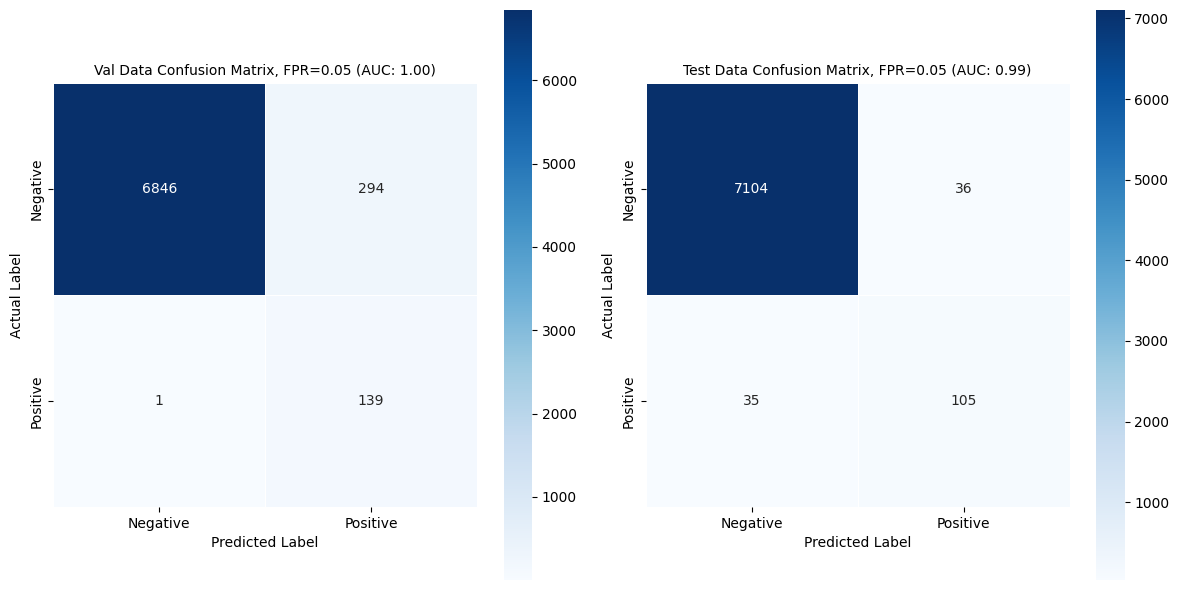

--------------------------------------------------
*experiment_idx = 1
- 36,500 total rows in features dict.
- 36,500 total rows in labels dict.


Epochs: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]


	- Best Val AUC Epoch: 189
	- Best Val AUC: 0.9986204481792718
	- Best Test AUC: 0.9965766306522609
	- TPR Target: 0.8
		- Validation Accuracy: 0.9942307692307693
		- Validation Recall: 0.7928571428571428
		- Test Accuracy: 0.9866758241758242
		- Test Recall: 0.3357142857142857


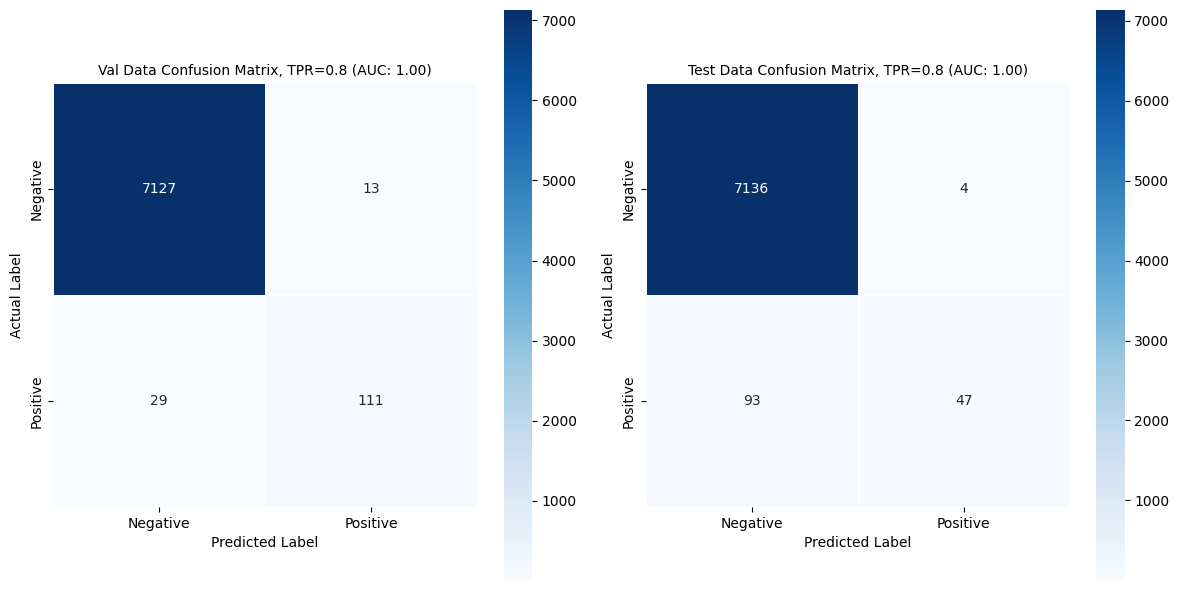

	- FPR Target: 0.05
		- Validation Accuracy: 0.9839285714285714
		- Validation Specificity: 0.9837535014005602
		- Test Accuracy: 0.989423076923077
		- Test Specificity: 0.9946778711484594


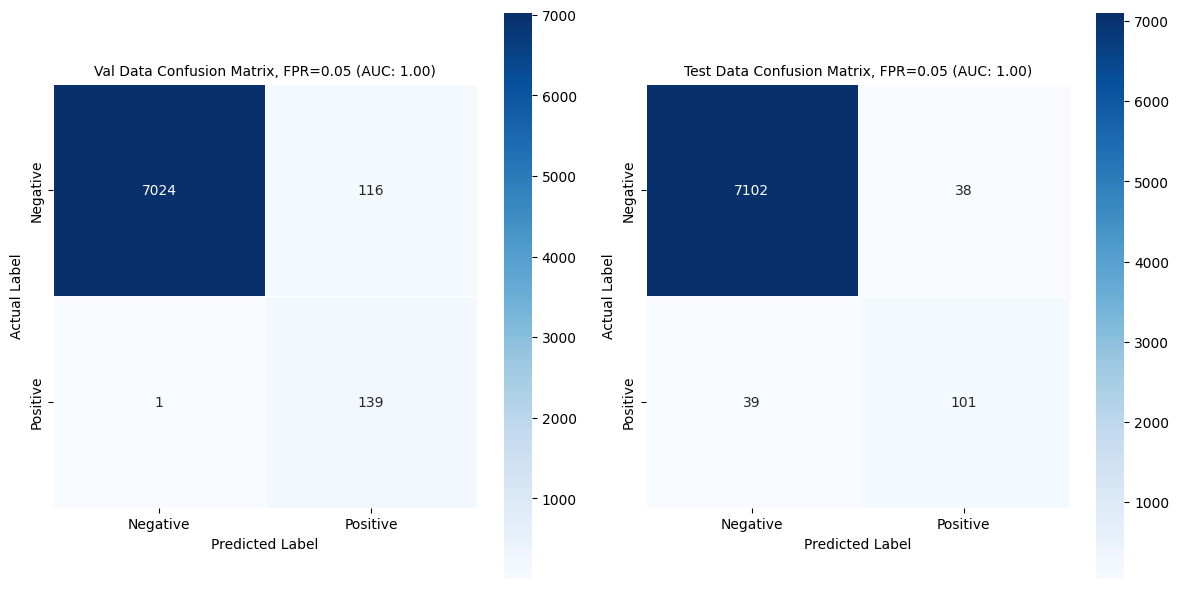

In [18]:
for experiment_idx, experiment_dict in hyperparameters_dict.items():
    print("-" * 50)
    print(f"*experiment_idx = {experiment_idx}")

    # get hyperparams from experiment_dict
    learning_rate = experiment_dict['learning_rate']

    # load data from file paths
    X_dict, y_dict = load_data(DATA_DIR, experiment_dict['features_file'], experiment_dict['targets_file'])

    # get overlap of keys of dictionaries
    keys_set = set(X_dict.keys()).intersection(set(y_dict.keys()))
    X_dict = {
        k: v for k, v in X_dict.items()
        if k in keys_set
    }
    y_dict = {
        k: v for k, v in y_dict.items()
        if k in keys_set
    }

    # convert each value in y_dict to a list
    y_dict = {
        k: [v] for k, v in y_dict.items()
    }

    # make MLP model
    model = make_mlp(
        input_dim = 45,
        hidden_dims = experiment_dict['mlp_layers'],
        output_dim = 1,
        hidden_activation = nn.ReLU,
        dropout = 0.0
    )

    # instantiate loss function
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # instantiate optimizer
    optimizer = optim.Adam(
        params = model.parameters(),
        lr = learning_rate,
        weight_decay = WEIGHT_DECAY
    )

    # split dictionaries into train-val-test arrays
    (
        X_train, X_val, X_test,
        y_train, y_val, y_test
    ) = get_train_val_test_arrays(
        X = X_dict,
        y = y_dict
    )

    # convert arrays to tensors
    X_train = torch.tensor(X_train, dtype = torch.float32)
    X_val = torch.tensor(X_val, dtype = torch.float32)
    X_test = torch.tensor(X_test, dtype = torch.float32)
    y_train = torch.tensor(y_train, dtype = torch.float32)
    y_val = torch.tensor(y_val, dtype = torch.float32)
    y_test = torch.tensor(y_test, dtype = torch.float32)

    # make Datasets
    train_dataset = get_tensordataset(
        X = X_train,
        y = y_train
    )
    val_dataset = get_tensordataset(
        X = X_val,
        y = y_val
    )
    test_dataset = get_tensordataset(
        X = X_test,
        y = y_test
    )

    # make DataLoaders
    train_loader = get_dataloader(
        dataset = train_dataset,
        shuffle = True
    )
    val_loader = get_dataloader(
        dataset = val_dataset,
        shuffle = False
    )
    test_loader = get_dataloader(
        dataset = test_dataset,
        shuffle = False
    )

    # train-val-test
    (
        best_val_auc_idx,
        best_val_y_true_list, best_val_y_hat_list,
        associated_test_y_true_list, associated_test_y_hat_list
    ) = train_validate_test(
            model = model,
            train_loader = train_loader,
            val_loader = val_loader,
            test_loader = test_loader,
            loss_fn = loss_fn,
            optimizer = optimizer,
            device = torch.device('cpu'),
            epochs = 200
    )

    # compute metrics of interest
    best_val_auc = roc_auc_score(
        y_true = best_val_y_true_list,
        y_score = best_val_y_hat_list
    )
    best_test_auc = roc_auc_score(
        y_true = associated_test_y_true_list,
        y_score = associated_test_y_hat_list
    )

    # print metrics of interest
    print(f"\t- Best Val AUC Epoch: {best_val_auc_idx}")
    print(f"\t- Best Val AUC: {best_val_auc}")
    print(f"\t- Best Test AUC: {best_test_auc}")

    # evaluate thresholds
    evaluate_thresholds(
    y_true_val = best_val_y_true_list,
    y_pred_val = best_val_y_hat_list,
    y_true_test = associated_test_y_true_list,
    y_pred_test = associated_test_y_hat_list,
    target_tprs = [0.8],
    target_fprs = [0.05]
)